In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [4]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [5]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [6]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [7]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [8]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Training

In [80]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(8,), kernel_regularizer=keras.regularizers.l2(0.01)),
#     keras.layers.BatchNormalization(gamma_regularizer=keras.regularizers.l2(0.01),
#                                    beta_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.01))
])
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [81]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
activation_9 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [82]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [83]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 1s 1ms/step - loss: 2.1100 - mean_absolute_error: 1.0932 - val_loss: 1.5123 - val_mean_absolute_error: 0.9457
Epoch 2/1000
825/825 [==============================] - 0s 408us/step - loss: 1.6705 - mean_absolute_error: 0.9830 - val_loss: 1.3078 - val_mean_absolute_error: 0.8893
Epoch 3/1000
825/825 [==============================] - 0s 428us/step - loss: 1.3994 - mean_absolute_error: 0.9012 - val_loss: 1.1660 - val_mean_absolute_error: 0.8430
Epoch 4/1000
825/825 [==============================] - 0s 446us/step - loss: 1.2148 - mean_absolute_error: 0.8411 - val_loss: 1.0713 - val_mean_absolute_error: 0.8117
Epoch 5/1000
825/825 [==============================] - 0s 423us/step - loss: 1.0947 - mean_absolute_error: 0.7986 - val_loss: 0.9939 - val_mean_absolute_error: 0.7859
Epoch 6/1000
825/825 [==============================] - 0s 412us/step - loss: 1.0016 - mean_absolute_error: 0.7628 -

825/825 [==============================] - 0s 407us/step - loss: 0.2298 - mean_absolute_error: 0.3007 - val_loss: 0.2884 - val_mean_absolute_error: 0.3359
Epoch 98/1000
825/825 [==============================] - 0s 320us/step - loss: 0.2284 - mean_absolute_error: 0.2993 - val_loss: 0.2861 - val_mean_absolute_error: 0.3353
Epoch 99/1000
825/825 [==============================] - 0s 267us/step - loss: 0.2280 - mean_absolute_error: 0.2978 - val_loss: 0.2850 - val_mean_absolute_error: 0.3326
Epoch 100/1000
825/825 [==============================] - 0s 262us/step - loss: 0.2270 - mean_absolute_error: 0.2979 - val_loss: 0.2842 - val_mean_absolute_error: 0.3332
Epoch 101/1000
825/825 [==============================] - 0s 281us/step - loss: 0.2262 - mean_absolute_error: 0.2964 - val_loss: 0.2855 - val_mean_absolute_error: 0.3337
Epoch 102/1000
825/825 [==============================] - 0s 428us/step - loss: 0.2254 - mean_absolute_error: 0.2953 - val_loss: 0.2831 - val_mean_absolute_error: 0.33

Epoch 145/1000
825/825 [==============================] - 0s 297us/step - loss: 0.2123 - mean_absolute_error: 0.2797 - val_loss: 0.2612 - val_mean_absolute_error: 0.3155
Epoch 146/1000
825/825 [==============================] - 0s 373us/step - loss: 0.2117 - mean_absolute_error: 0.2798 - val_loss: 0.2620 - val_mean_absolute_error: 0.3169
Epoch 147/1000
825/825 [==============================] - 0s 422us/step - loss: 0.2112 - mean_absolute_error: 0.2780 - val_loss: 0.2613 - val_mean_absolute_error: 0.3149
Epoch 148/1000
825/825 [==============================] - 0s 360us/step - loss: 0.2109 - mean_absolute_error: 0.2780 - val_loss: 0.2630 - val_mean_absolute_error: 0.3169
Epoch 149/1000
825/825 [==============================] - 0s 383us/step - loss: 0.2113 - mean_absolute_error: 0.2789 - val_loss: 0.2609 - val_mean_absolute_error: 0.3161
Epoch 150/1000
825/825 [==============================] - 0s 392us/step - loss: 0.2111 - mean_absolute_error: 0.2788 - val_loss: 0.2602 - val_mean_abs

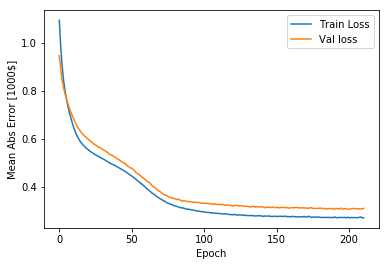

In [84]:
plot_history(history)

In [85]:
pred = y_scaler.inverse_transform(model.predict(X_test).flatten())
msse(pred, y_test)

47.55911260790781

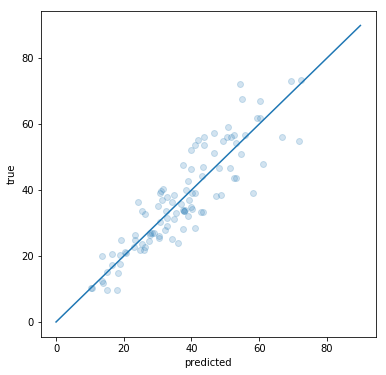

In [86]:
plot_predictions(pred, y_test)

In [87]:
weights = model.get_weights()
np.save('relu_weights', weights, allow_pickle=True)

In [79]:
weights

[array([[-0.2940661 , -0.72649795,  0.26784873, -0.01275   ,  0.05159631,
          0.19937965,  0.4957078 , -0.677582  ],
        [-0.18589935,  0.3053185 ,  0.32740837, -0.01853047,  0.2605685 ,
         -0.01544619,  0.2650567 , -0.90921   ],
        [-0.22197302,  0.1588767 ,  0.07698399,  0.10850101,  0.03795526,
         -0.3584859 ,  0.0118272 , -0.0863139 ],
        [-0.24691616, -0.11789902,  0.21716851,  0.13796748, -0.7025057 ,
          0.40240264, -0.17295994, -0.02875581],
        [-0.08599241, -0.6561444 , -0.01312288,  0.20174484, -0.17516798,
          0.00304133,  0.19871004, -0.17969967],
        [-0.15913615,  0.20921569,  0.277745  ,  0.0163471 ,  0.23869854,
          0.2737866 , -0.13812985, -0.08812128],
        [-0.29698336,  0.25426036,  0.35785776,  0.01718658, -0.1250565 ,
          0.2133554 , -0.19901738,  0.15225694],
        [-0.19117534, -0.2994989 , -0.6954956 , -0.8107696 ,  0.09658636,
          0.5533975 ,  0.3482275 ,  0.01318343]], dtype=float32),